In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import numpy.typing as npt
from tqdm import tqdm
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

In [17]:
def simulate_one(
    n: int, 
    eta_g: float, 
    n_batch: int, 
    frame: str,
    seed: int=0
) -> npt.NDArray[np.float64]:
    """Simulate one run of whitening algorithm with random cov and given frame."""
    assert frame in ["GRASSMANN", "RANDN"]
    np.random.seed(seed)
    # setup
    k = n * (n + 1) // 2
    rng = np.random.default_rng(seed=seed)
    V, _ = np.linalg.qr(rng.standard_normal((n, n)))
    s = np.exp((np.linspace(-3, 3, n) + rng.standard_normal((n, )))*.1) 

    Cxx = V @ np.diag(s) @ V.T
    if frame == "GRASSMANN":
        W, _ = fw.get_grassmannian(n, k, rng)
    else: # frame == "RANDN":
        W = rng.standard_normal((n, k))
    W = fw.normalize_frame(W)

    _, _, errors, _ = fws.adapt_covariance(
        [Cxx], W, 0, n_batch, eta_g, None, False, False, 1., verbose=False
        )

    return errors

def simulate_many(
    n: int,
    n_steps: int,
    n_repeats: int, 
    lr: float,
    frame: str,
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel."""

    with multiprocessing.Pool() as pool:
        all_errors = []
        pbar = tqdm(total=n_repeats)
        for errors in pool.starmap(simulate_one, [(n, lr, n_steps, frame, i) for i in range(n_repeats)]):
            if len(errors) != n_steps:
                errors = errors + [errors[-1]] * (n_steps - len(errors))
            all_errors.append(errors)
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors

In [23]:
n_repeats = 100
n = 16
n_steps = 8096
lr = 5E-3
all_errors_randn = simulate_many(n, n_steps, n_repeats, lr, "RANDN")
all_errors_grassmann = simulate_many(n, n_steps, n_repeats, lr, "GRASSMANN")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.05it/s]


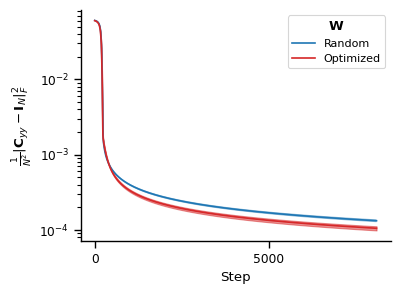

In [26]:
# fmt: off
def get_mean_sem(x):
    return np.mean(x, axis=0), np.std(x, axis=0) / np.sqrt(x.shape[0])

with sns.plotting_context("paper", font_scale=1):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3) ,dpi=100)

    mu_randn, sig_randn = get_mean_sem(all_errors_randn)
    mu_opt, sig_opt = get_mean_sem(all_errors_grassmann)

    ax.plot(range(len(mu_randn)), mu_randn, color="C0", label="Random")
    ax.fill_between(range(len(mu_randn)), mu_randn - sig_randn, mu_randn + sig_randn, alpha=0.5)

    ax.plot(range(len(mu_opt)), mu_opt, color="C3", label="Optimized")
    ax.fill_between(range(len(mu_opt)), mu_opt - sig_opt, mu_opt + sig_opt, color="C3", alpha=0.5)

    ax.set(yscale="log", ylabel=r"$\frac{1}{N^2}\|{\bf C}_{yy} - {\bf I}_N\|_F^2$", 
    xlabel="Step", xticks=(0, 5000))

    ax.legend(title=r"${\bf W}$", fontsize=8, loc="upper right")

    sns.despine()
# fmt: on